In [10]:
model_name = 'nassm/convnext_nano' # Pre-trained model name
batch_size=32
num_workers=64

In [11]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
def normalize(array):
    """
    Normalize values between 0 and 1 using min-max scaling
    
    Args:
        array: pandas Series containing values to normalize
    
    Returns:
        tuple: (pandas Series with normalized values between 0 and 1 as float32, fitted scaler)
    """
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(array.values.reshape(-1, 1))
    return pd.Series(normalized.flatten(), index=array.index, name='norm', dtype='float32'), scaler

In [12]:
#---------------------#
path = '/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/'
label='Vm' # km/s
id_str = 'plateifu'
#---------------------#

train_ = pd.read_csv('rot/train_dataset.csv')
test_ = pd.read_csv('rot/test_dataset.csv')

train_['file_loc'] = path + train_['file_loc'].astype(str)
train_['id_str'] = train_[id_str]
test_['file_loc'] = path + test_['file_loc'].astype(str)
test_['id_str'] = test_[id_str]


In [13]:
# Normalize label column
import numpy as np
train_[label] = normalize(np.abs(train_[label]))[0]
test_[label] = normalize(np.abs(test_[label]))[0]

In [14]:
from galaxy_datasets.pytorch.galaxy_datamodule import CatalogDataModule
from galaxy_datasets.transforms import default_view_config, get_galaxy_transform
batch_size=32
num_workers=64


transform_cfg = default_view_config()
transform = get_galaxy_transform(transform_cfg)


datamodule = CatalogDataModule(
    label_cols = [label, 'nsa_sersic_mass'],
    catalog = train_,
    train_transform = transform,
    test_transform = transform,
    batch_size= batch_size,
    num_workers= num_workers
    )

In [15]:
datamodule.label_cols

['Vm', 'nsa_sersic_mass']

In [16]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotMetadataRegressor
model = FinetuneableZoobotMetadataRegressor(
    label_col=label,
    name='nassm/convnext_nano',
    learning_rate=1e-6,  
    unit_interval=True,
    metadata_cols=['nsa_sersic_mass'])

In [17]:
from zoobot.pytorch.training.finetune import get_trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
save_dir = '/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/training'

csv_logger = CSVLogger(
    save_dir=save_dir,
    name='training_logs',
    version=None
)
trainer = get_trainer(
    save_dir,
    accelerator='auto',
    devices='auto',
    max_epochs=100,
    logger=csv_logger,
    enable_checkpointing=True
        )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, datamodule)

/home/nasserm/local/miniconda3/envs/mangazoo/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | encoder           | ConvNeXt         | 15.0 M | train
1 | train_loss_metric | MeanMetric       | 0      | train
2 | val_loss_metric   | MeanMetric       | 0      | train
3 | test_loss_metric  | MeanMetric       | 0      | train
4 | head              | LinearHead       | 642    | train
5 | train_rmse        | MeanSquaredError | 0      | train
6 | val_rmse          | MeanSquaredError | 0      | train
7 | test_rmse         | MeanSquaredError | 0      | train
---------------------------------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
59.813    Total estimated model params size (MB)
210       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/geir_data/scr/nasserm/zoobot/zoobot/pytorch/training/finetune.py:1062: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch['image'], dtype=torch.float, device=self.device)
/geir_data/scr/nasserm/zoobot/zoobot/pytorch/training/finetune.py:1068: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(batch[col], dtype=torch.float, device=x.device).unsqueeze(1)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'finetuning/val_loss' reached 0.18360 (best 0.18360), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/0-v9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'finetuning/val_loss' reached 0.17823 (best 0.17823), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/1-v7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'finetuning/val_loss' reached 0.11893 (best 0.11893), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'finetuning/val_loss' reached 0.08919 (best 0.08919), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'finetuning/val_loss' reached 0.08326 (best 0.08326), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/4-v9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300: 'finetuning/val_loss' reached 0.05587 (best 0.05587), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 350: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 400: 'finetuning/val_loss' reached 0.04856 (best 0.04856), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 450: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 500: 'finetuning/val_loss' reached 0.04005 (best 0.04005), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/9-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 550: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 600: 'finetuning/val_loss' reached 0.03970 (best 0.03970), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/11.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 650: 'finetuning/val_loss' reached 0.03396 (best 0.03396), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 700: 'finetuning/val_loss' reached 0.03042 (best 0.03042), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 750: 'finetuning/val_loss' reached 0.03019 (best 0.03019), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 800: 'finetuning/val_loss' reached 0.02885 (best 0.02885), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 850: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 900: 'finetuning/val_loss' reached 0.02727 (best 0.02727), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/17.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 950: 'finetuning/val_loss' reached 0.02629 (best 0.02629), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1000: 'finetuning/val_loss' reached 0.02547 (best 0.02547), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 1050: 'finetuning/val_loss' reached 0.02448 (best 0.02448), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/20.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 1100: 'finetuning/val_loss' reached 0.02301 (best 0.02301), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/21.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 1150: 'finetuning/val_loss' reached 0.02113 (best 0.02113), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/22.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 1200: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 1250: 'finetuning/val_loss' reached 0.02037 (best 0.02037), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/24-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 1300: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 1350: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 1400: 'finetuning/val_loss' reached 0.01930 (best 0.01930), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/27.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 1450: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 1500: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 1550: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 1600: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 1650: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 1700: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 1750: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 1800: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 1850: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 1900: 'finetuning/val_loss' reached 0.01880 (best 0.01880), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/37.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 1950: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 2000: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 2050: 'finetuning/val_loss' reached 0.01614 (best 0.01614), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/40.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 2100: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 2150: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 2200: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 2250: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 2300: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 2350: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 2400: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 2450: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 2500: 'finetuning/val_loss' reached 0.01587 (best 0.01587), saving model to '/geir_data/scr/nasserm/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/49.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 2550: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 2600: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 2650: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 2700: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 2750: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 2800: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 2850: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 2900: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 2950: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 3000: 'finetuning/val_loss' was not in top 1


In [41]:
from zoobot.pytorch.predictions import predict_on_catalog
best_checkpoint = trainer.checkpoint_callback.best_model_path
best_checkpoint = ckpt = '/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/training/checkpoints/49.ckpt'
finetuned_model = FinetuneableZoobotMetadataRegressor.load_from_checkpoint(best_checkpoint)

In [42]:
import torch
predictions_path='/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/training/preds/save4a.csv'
predict_catalog = test_.copy()

predict_datamodule = CatalogDataModule(
    label_cols=['nsa_sersic_mass'],
    predict_catalog=predict_catalog,
    test_transform=transform
)

import lightning as L
trainer = L.Trainer(max_epochs=-1)

# Run predictions (returns list of tensors per batch), concatenate and convert
preds_tensor = torch.cat(trainer.predict(finetuned_model, predict_datamodule), dim=0)
preds_np = preds_tensor.detach().cpu().numpy()

# Handle shapes: (N,), (N,1), or (N,k)
if preds_np.ndim == 1:
    primary = preds_np
    extra = None
elif preds_np.ndim == 2 and preds_np.shape[1] == 1:
    primary = preds_np.flatten()
    extra = None
elif preds_np.ndim == 2 and preds_np.shape[1] > 1:
    # multiple outputs per sample (keep first as primary and store extras)
    primary = preds_np[:, 0]
    extra = preds_np[:, 1:]
else:
    # unexpected shape — coerce to 1D primary
    primary = preds_np.flatten()
    extra = None

# Ensure primary is numpy array
primary = np.asarray(primary)

# Inverse-transform predictions to raw units if scaler provided
try:
    pred_raw = scaler.inverse_transform(primary.reshape(-1, 1)).flatten()
except Exception:
    pred_raw = primary

# Build a predictions DataFrame that includes id_str and both normalized and raw predicted label
predictions_result = pd.DataFrame({
    'id_str': predict_catalog['id_str'].values,
    'label': primary,
    'label_raw': pred_raw
})

# If there are extra columns, add them as label_1, label_2, ... (keep them in normalized space)
if extra is not None:
    for i in range(extra.shape[1]):
        predictions_result[f'label_{i+1}'] = extra[:, i]

# Save predictions with id column and raw predictions so downstream merging works and is in original units
# write only id_str and raw prediction to CSV to satisfy request
predictions_result[['id_str', 'label_raw']].to_csv(predictions_path, index=False)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/geir_data/scr/nasserm/zoobot/zoobot/pytorch/training/finetune.py:1062: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch['image'], dtype=torch.float, device=self.device)
/geir_data/scr/nasserm/zoobot/zoobot/pytorch/training/finetune.py:1068: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(batch[col], dtype=torch.float, device=x.device).unsqueeze(1)


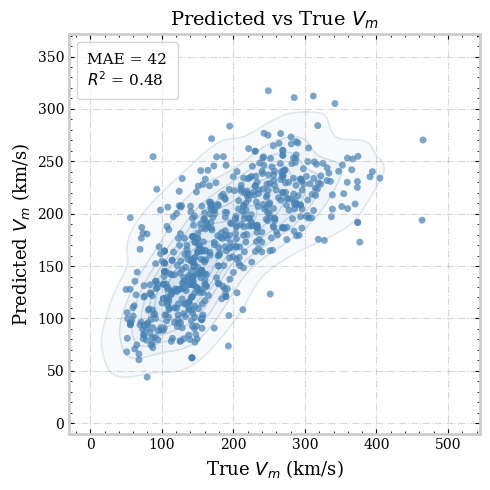

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib.lines import Line2D

def plot_form(ax):
    ax.grid(ls='-.', alpha=0.5, zorder=0)
    ax.tick_params(direction='in')
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_linewidth(2)
        ax.spines[spine].set_color('0.8')
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.minorticks_on()
    plt.rcParams['font.family'] = 'serif'

# Merge predictions with true values using id_str
merged = test_.merge(predictions_result, on='id_str')

# helper: metrics legend
def add_metrics_legend(ax, y_true, y_pred):
    def sigfig(x, n=2):
        if x == 0:
            return "0"
        return f"{x:.{n}g}"
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    text = f"MAE = {sigfig(mae, 3)}\n$R^2$ = {sigfig(r2, 2)}"
    handle = Line2D([], [], marker='o', color='w', alpha=0, linestyle='None')
    ax.legend([handle], [text], loc='upper left', fontsize=11, frameon=True,
              borderpad=0.7, labelspacing=0.3, handlelength=0, handletextpad=0)

# helper: contours
def plot_contours(ax, x, y):
    cmap = sns.light_palette('steelblue', as_cmap=True)
    if len(x) > 10:
        try:
            sns.kdeplot(x=x, y=y, ax=ax, fill=True, cmap=cmap,
                        levels=8, thresh=0.05, alpha=0.25, zorder=0)
            sns.kdeplot(x=x, y=y, ax=ax, color='steelblue',
                        levels=8, thresh=0.05, linewidths=1.2,
                        fill=False, alpha=0.15, zorder=1)
        except Exception:
            pass

# --- Un-normalize before plotting ---
import numpy as np
from sklearn.preprocessing import MinMaxScaler

x = merged['Vm']       # default: normalized true
y = merged['label']    # default: normalized predicted

units = ''
# Try to rebuild the scaler used for normalization from the raw training labels
try:
    raw_train = pd.read_csv('rot/train_dataset.csv')
    scaler = MinMaxScaler()
    scaler.fit(np.abs(raw_train[label]).values.reshape(-1, 1))  # normalization used abs(...) when fitting

    x_norm = merged['Vm'].values.reshape(-1, 1)
    y_norm = merged['label'].values.reshape(-1, 1)

    # inverse transform to original units
    x = scaler.inverse_transform(x_norm).flatten()
    y = scaler.inverse_transform(y_norm).flatten()
    units = ' (km/s)'
except Exception:
    # if anything goes wrong, keep x,y as normalized values
    x = merged['Vm']
    y = merged['label']
    units = ''

# plot
fig, ax = plt.subplots(figsize=(5, 5))
plot_form(ax)

plot_contours(ax, x, y)
sns.scatterplot(x=x, y=y, ax=ax, alpha=0.7, s=25, color='steelblue', edgecolor='none')

# 1:1 reference line and sensible limits depending on units
# try:
#     mn = min(np.nanmin(x), np.nanmin(y))
#     mx = max(np.nanmax(x), np.nanmax(y))
#     pad = 0.05 * (mx - mn) if mx > mn else 0.1
#     ax.plot([mn - pad, mx + pad], [mn - pad, mx + pad], color='black', linestyle='--', linewidth=2)
#     ax.set_xlim(mn - pad, mx + pad)
#     ax.set_ylim(mn - pad, mx + pad)
# except Exception:
#     # fallback to normalized axis limits
#     ax.plot([x.min()-0.1, x.max()], [x.min()-0.1, x.max()], color='black', linestyle='--', linewidth=2)
#     ax.set_xlim(-0.1, 1)
#     ax.set_ylim(-0.1, 1)

# labels and title
ax.set_xlabel(f'True $V_m${units}', fontsize=13)
ax.set_ylabel(f'Predicted $V_m${units}', fontsize=13)
ax.set_title('Predicted vs True $V_m$', fontsize=14)

# add metrics legend (use current x,y which are in plotted units)
add_metrics_legend(ax, x, y)

plt.tight_layout()
plt.show()

In [30]:
import pandas as pd
train_pred = pd.read_csv('/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/training/preds/save4.csv')

In [31]:
train_pred

,id_str,label_raw
0,8728-9102,1701.07530
1,8710-6103,3161.89920
2,8591-12702,1687.85970
3,11948-12703,-12808.12500
4,9025-9102,2670.12280
...,...,...
573,9881-12702,2736.46070
574,9510-12703,1253.72420
575,9878-12701,-324.81558
576,8088-9102,-10770.63200


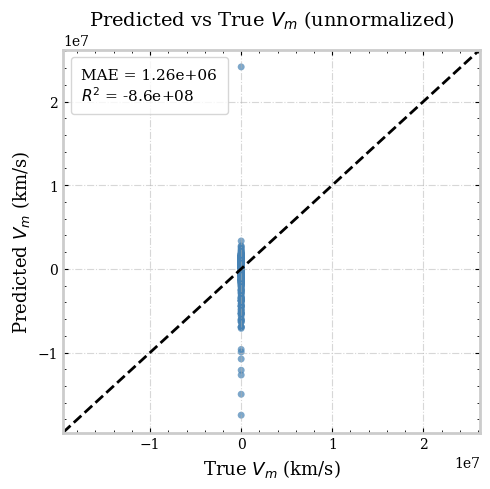

In [33]:
# un-normalize predictions and true values before metrics/plotting
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# reload original (raw) training labels to fit the same scaler used for normalization
raw_train = pd.read_csv('rot/train_dataset.csv')

scaler = MinMaxScaler()
scaler.fit(np.abs(raw_train[label]).values.reshape(-1, 1))  # normalization used abs(...) when fitting

# Merge predictions with true values using id_str
merged = test_.merge(train_pred, on='id_str')

# get normalized series
x_norm = merged['Vm'].values.reshape(-1, 1)   # true (normalized)
y_norm = merged['label_raw'].values.reshape(-1, 1)  # predicted (normalized)

# inverse transform to original units
x = scaler.inverse_transform(x_norm).flatten()
y = scaler.inverse_transform(y_norm).flatten()

# plotting (reuse helpers defined previously)
fig, ax = plt.subplots(figsize=(5, 5))
plot_form(ax)

plot_contours(ax, x, y)
sns.scatterplot(x=x, y=y, ax=ax, alpha=0.7, s=25, color='steelblue', edgecolor='none')

# 1:1 reference line in original units
mn = min(x.min(), y.min())
mx = max(x.max(), y.max())
pad = 0.05 * (mx - mn) if mx > mn else 1.0
ax.plot([mn - pad, mx + pad], [mn - pad, mx + pad], color='black', linestyle='--', linewidth=2)

# labels and title (original units)
ax.set_xlabel('True $V_m$ (km/s)', fontsize=13)
ax.set_ylabel('Predicted $V_m$ (km/s)', fontsize=13)
ax.set_title('Predicted vs True $V_m$ (unnormalized)', fontsize=14)
ax.set_xlim(mn - pad, mx + pad)
ax.set_ylim(mn - pad, mx + pad)

# add metrics legend using un-normalized values
add_metrics_legend(ax, x, y)

plt.tight_layout()
plt.show()